# Example 15 - Three Point Problem

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 1187 m wide (W-E extent) and 1479 m high (N-S extent). This example represents a classic "three-point-problem" of a planar dipping layer. The interface points were not recorded at the surface but rather in boreholes at depth. The fault has an offset of 20 m but no further interface points are located beyond the fault. This will be dealt with in a two model approach.

The map has been georeferenced with QGIS. The outcrops of the layers were digitized in QGIS. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example15.png" width="800">

Map Source: An Introduction to Geological Structures and Maps by G.M. Bennison

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded form an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example15/'
gg.download_gemgis_data.download_tutorial_data(filename="example15_three_point_problem.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example15.png" width="800">

In [4]:
topo = gpd.read_file(file_path + 'topo15.shp')
topo.head()

,id,Z,geometry
0,None,180,"LINESTRING (608.177 -0.021, 598.911 22.516, 58..."
1,None,190,"LINESTRING (323.662 216.425, 321.832 254.178, ..."
2,None,200,"LINESTRING (142.794 190.113, 153.433 227.980, ..."
3,None,250,"LINESTRING (1.395 1193.695, 20.385 1232.592, 3..."
4,None,240,"LINESTRING (1.623 925.311, 8.487 939.039, 13.7..."


### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=5)

### Plotting the raster

Text(114.71511083600905, 0.5, 'Y [m]')

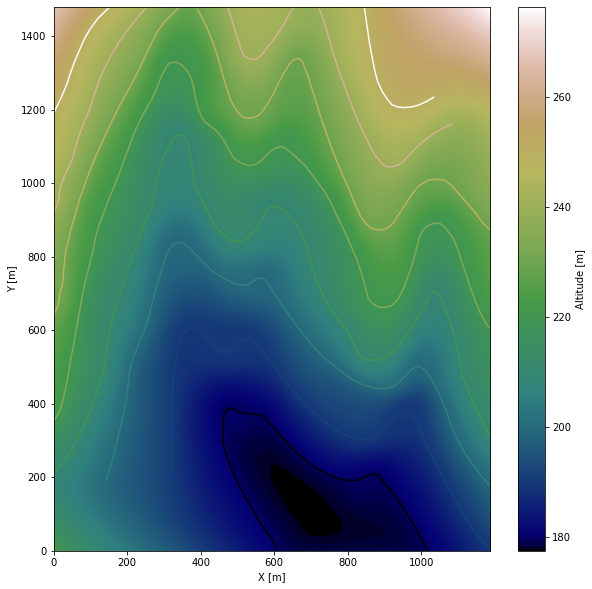

In [6]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1, figsize=(10,10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0,1187,0,1479], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as as raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster15.tif')

## Interface Points of stratigraphic boundaries

The interface points for this three point example will be digitized as points with the respective height value as given by the contour lines and the respective formation.  

<img src="../images/interfaces_example15.png" width="800">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces15.shp')
interfaces.head()

,id,formation,Z,geometry
0,None,Shale,190,POINT (69.806 954.941)
1,None,Ironstone,170,POINT (69.806 954.941)
2,None,Ironstone,190,POINT (145.769 562.774)
3,None,Ironstone,185,POINT (264.746 660.701)
4,None,Shale,210,POINT (146.226 563.346)


### Extracting Z coordinate from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=None)
interfaces_coords

,formation,Z,geometry,X,Y
0,Shale,190.00,POINT (69.806 954.941),69.81,954.94
1,Ironstone,170.00,POINT (69.806 954.941),69.81,954.94
2,Ironstone,190.00,POINT (145.769 562.774),145.77,562.77
3,Ironstone,185.00,POINT (264.746 660.701),264.75,660.70
4,Shale,210.00,POINT (146.226 563.346),146.23,563.35
5,Shale,205.00,POINT (264.746 660.701),264.75,660.70


In [10]:
fault = gpd.read_file(file_path + 'fault15.shp')
fault = gg.vector.extract_xyz(gdf=fault, dem=topo_raster)
fault

,formation,geometry,X,Y,Z
0,Fault,POINT (683.911 0.608),683.91,0.61,178.76
1,Fault,POINT (899.671 1477.524),899.67,1477.52,254.62


In [11]:
import pandas as pd

interfaces_coords = pd.concat([interfaces_coords, fault]).reset_index()
interfaces_coords

,index,formation,Z,geometry,X,Y
0,0,Shale,190.00,POINT (69.806 954.941),69.81,954.94
1,1,Ironstone,170.00,POINT (69.806 954.941),69.81,954.94
2,2,Ironstone,190.00,POINT (145.769 562.774),145.77,562.77
3,3,Ironstone,185.00,POINT (264.746 660.701),264.75,660.70
4,4,Shale,210.00,POINT (146.226 563.346),146.23,563.35
5,5,Shale,205.00,POINT (264.746 660.701),264.75,660.70
6,0,Fault,178.76,POINT (683.911 0.608),683.91,0.61
7,1,Fault,254.62,POINT (899.671 1477.524),899.67,1477.52


### Plotting the Interface Points

Text(179.77829589465532, 0.5, 'Y [m]')

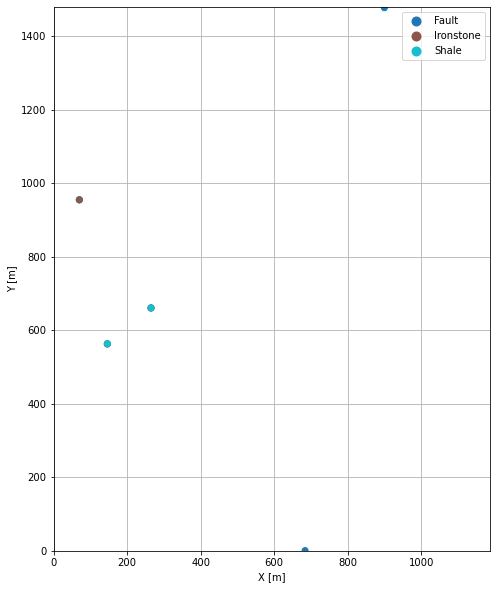

In [12]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlim(0,1187)
plt.ylim(0,1479)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Orientations from Strike Lines

For this three point example, an orientation is calculated using `gg.vector.calculate_orientation_for_three_point_problem()`. 

<img src="../images/orientations_example15.png" width="800">

In [13]:
orientations1 = gpd.read_file(file_path + 'interfaces15.shp')
orientations1 = orientations1[orientations1['formation']=='Ironstone']
orientations1

,id,formation,Z,geometry
1,None,Ironstone,170,POINT (69.806 954.941)
2,None,Ironstone,190,POINT (145.769 562.774)
3,None,Ironstone,185,POINT (264.746 660.701)


In [14]:
orientations1 = gg.vector.calculate_orientation_for_three_point_problem(gdf=orientations1)
orientations1

,Z,formation,azimuth,dip,polarity,X,Y,geometry
0,181.67,Ironstone,-179.95,177.08,1,160.11,726.14,POINT (160.107 726.139)


In [15]:
orientations1['Z'] = orientations1['Z'].astype(float)
orientations1['azimuth'] = orientations1['azimuth'].astype(float)
orientations1['dip'] = orientations1['dip'].astype(float)
orientations1['dip'] = 180 - orientations1['dip']
orientations1['azimuth'] = 180 - orientations1['azimuth']
orientations1['polarity'] = orientations1['polarity'].astype(float)
orientations1['X'] = orientations1['X'].astype(float)
orientations1['Y'] = orientations1['Y'].astype(float)
orientations1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Z          1 non-null      float64 
 1   formation  1 non-null      object  
 2   azimuth    1 non-null      float64 
 3   dip        1 non-null      float64 
 4   polarity   1 non-null      float64 
 5   X          1 non-null      float64 
 6   Y          1 non-null      float64 
 7   geometry   1 non-null      geometry
dtypes: float64(6), geometry(1), object(1)
memory usage: 192.0+ bytes


In [16]:
orientations2 = gpd.read_file(file_path + 'interfaces15.shp')
orientations2 = orientations2[orientations2['formation']=='Shale']
orientations2

,id,formation,Z,geometry
0,None,Shale,190,POINT (69.806 954.941)
4,None,Shale,210,POINT (146.226 563.346)
5,None,Shale,205,POINT (264.746 660.701)


In [17]:
orientations2 = gg.vector.calculate_orientation_for_three_point_problem(gdf=orientations2)
orientations2

,Z,formation,azimuth,dip,polarity,X,Y,geometry
0,201.67,Shale,-179.77,177.07,1,160.26,726.33,POINT (160.259 726.329)


In [18]:
orientations2['Z'] = orientations2['Z'].astype(float)
orientations2['azimuth'] = orientations2['azimuth'].astype(float)
orientations2['dip'] = orientations2['dip'].astype(float)
orientations2['dip'] = 180 - orientations2['dip']
orientations2['azimuth'] = 180 - orientations2['azimuth']
orientations2['polarity'] = orientations2['polarity'].astype(float)
orientations2['X'] = orientations2['X'].astype(float)
orientations2['Y'] = orientations2['Y'].astype(float)
orientations2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Z          1 non-null      float64 
 1   formation  1 non-null      object  
 2   azimuth    1 non-null      float64 
 3   dip        1 non-null      float64 
 4   polarity   1 non-null      float64 
 5   X          1 non-null      float64 
 6   Y          1 non-null      float64 
 7   geometry   1 non-null      geometry
dtypes: float64(6), geometry(1), object(1)
memory usage: 192.0+ bytes


In [19]:
orientations_fault = gpd.read_file(file_path + 'orientations15_fault.shp')
orientations_fault = gg.vector.extract_xyz(gdf=orientations_fault, dem=topo_raster)
orientations_fault

,formation,dip,azimuth,polarity,geometry,X,Y,Z
0,Fault,90.00,280.00,1.00,POINT (792.591 727.511),792.59,727.51,215.87


In [20]:
orientations = pd.concat([orientations1, orientations2, orientations_fault]).reset_index()
orientations

,index,Z,formation,azimuth,dip,polarity,X,Y,geometry
0,0,181.67,Ironstone,359.95,2.92,1.00,160.11,726.14,POINT (160.107 726.139)
1,0,201.67,Shale,359.77,2.93,1.00,160.26,726.33,POINT (160.259 726.329)
2,0,215.87,Fault,280.00,90.00,1.00,792.59,727.51,POINT (792.591 727.511)


### Plotting the Orientations

Text(179.77829589465532, 0.5, 'Y [m]')

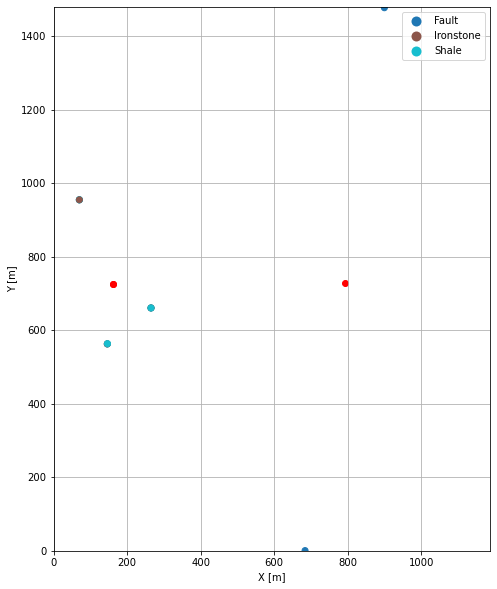

In [21]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlim(0,1187)
plt.ylim(0,1479)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## GemPy Model Construction (Part A)

The structural geological model will be constructed using the `GemPy` package. The first model is calculated without the fault. 

In [22]:
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Creating New Model

In [ ]:
geo_model = gp.create_model('Model15a')
geo_model

### Initiate Data

The fault interfaces and orientations will be removed from the first model to model the layers also beyond the fault. As the information is provided that the fault has an offset of 20 m, the layers will be exported, the boundaries will be digitized and the elevation will be reduced by 20 m. 

In [24]:
interfaces_coords_new = interfaces_coords[interfaces_coords['formation']!='Fault']
interfaces_coords_new

,index,formation,Z,geometry,X,Y
0,0,Shale,190.00,POINT (69.806 954.941),69.81,954.94
1,1,Ironstone,170.00,POINT (69.806 954.941),69.81,954.94
2,2,Ironstone,190.00,POINT (145.769 562.774),145.77,562.77
3,3,Ironstone,185.00,POINT (264.746 660.701),264.75,660.70
4,4,Shale,210.00,POINT (146.226 563.346),146.23,563.35
5,5,Shale,205.00,POINT (264.746 660.701),264.75,660.70


In [25]:
orientations_new = orientations[orientations['formation']!='Fault']
orientations_new

,index,Z,formation,azimuth,dip,polarity,X,Y,geometry
0,0,181.67,Ironstone,359.95,2.92,1.00,160.11,726.14,POINT (160.107 726.139)
1,0,201.67,Shale,359.77,2.93,1.00,160.26,726.33,POINT (160.259 726.329)


In [26]:
gp.init_data(geo_model, [0,1187,0,1479,100,300], [100,100,100],
             surface_points_df = interfaces_coords_new[interfaces_coords_new['Z']!=0],
             orientations_df = orientations_new,
             default_values=True)

Active grids: ['regular']


Model15a  2021-04-03 15:54

### Model Surfaces

In [27]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Shale,Default series,1,#015482,1
1,Ironstone,Default series,2,#9f0052,2


### Mapping the Stack to Surfaces

In [28]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Strata1': ('Shale', 'Ironstone'),
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')

,surface,series,order_surfaces,color,id
0,Shale,Strata1,1,#015482,1
1,Ironstone,Strata1,2,#9f0052,2
2,Basement,Strata1,3,#ffbe00,3


### Showing the Number of Data Points

In [29]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,Shale,Strata1,1,#015482,1,3,1
1,Ironstone,Strata1,2,#9f0052,2,3,1
2,Basement,Strata1,3,#ffbe00,3,0,0


### Loading Digital Elevation Model

In [30]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster15.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   5.935     ,    7.395     ,  101.        ],
       [   5.935     ,    7.395     ,  103.        ],
       [   5.935     ,    7.395     ,  105.        ],
       ...,
       [1184.49578059, 1466.50844595,  275.3008728 ],
       [1184.49578059, 1471.50506757,  275.80532837],
       [1184.49578059, 1476.50168919,  276.31124878]])

### Plotting Input Data

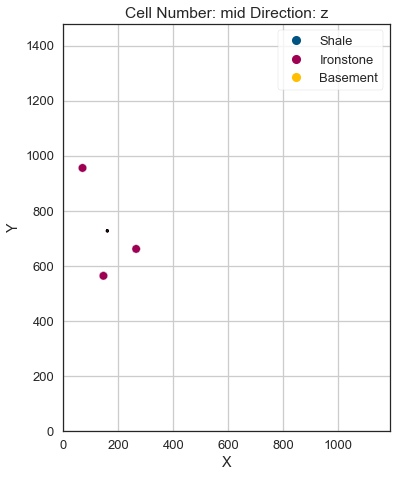

In [31]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

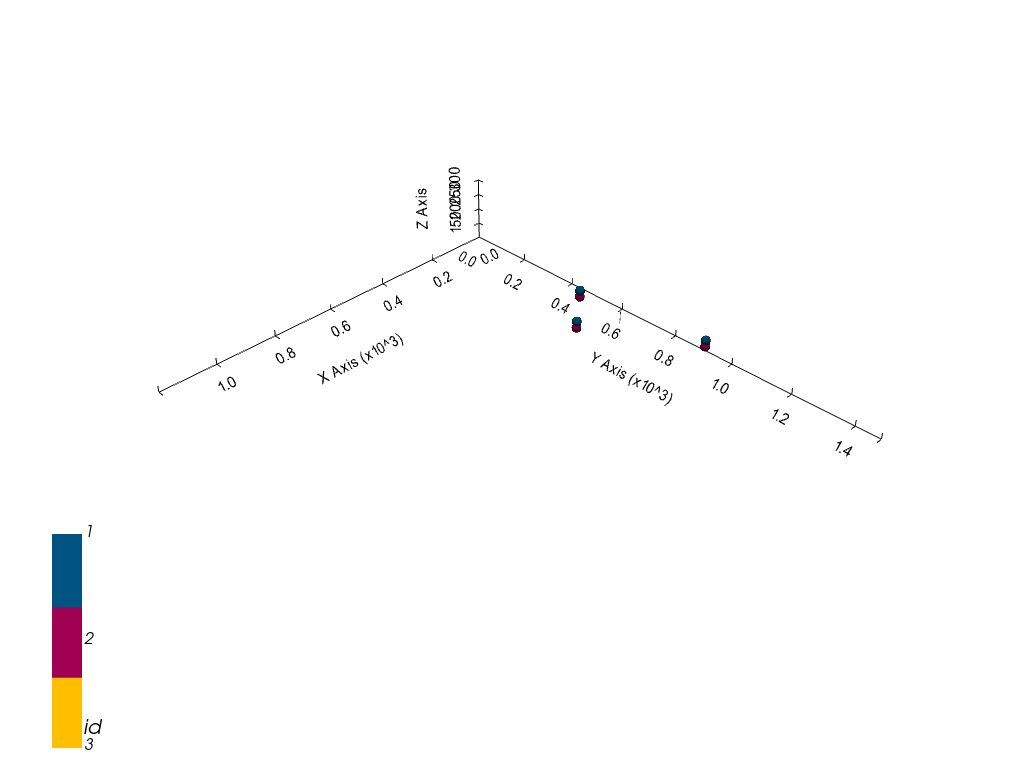

In [32]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [33]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1906.94
$C_o$           86581.19
drift equations      [3]


### Computing Model

In [34]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

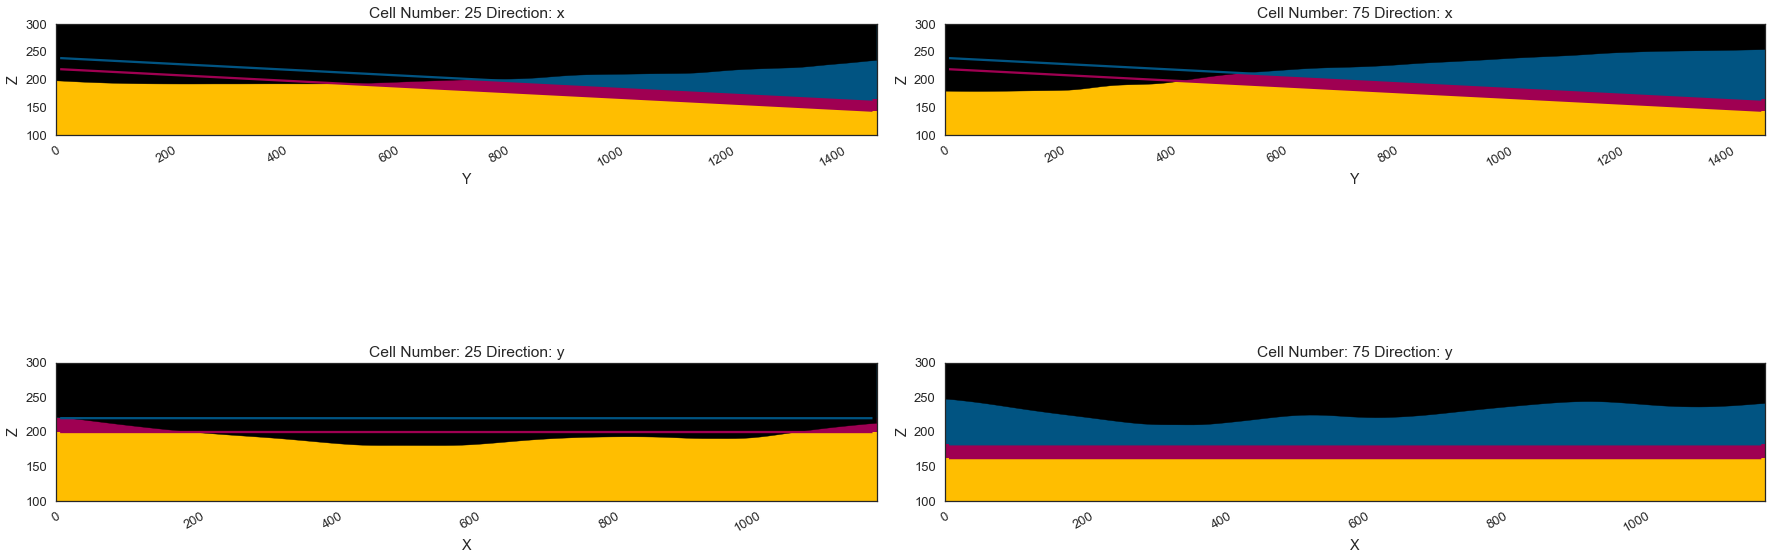

In [35]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

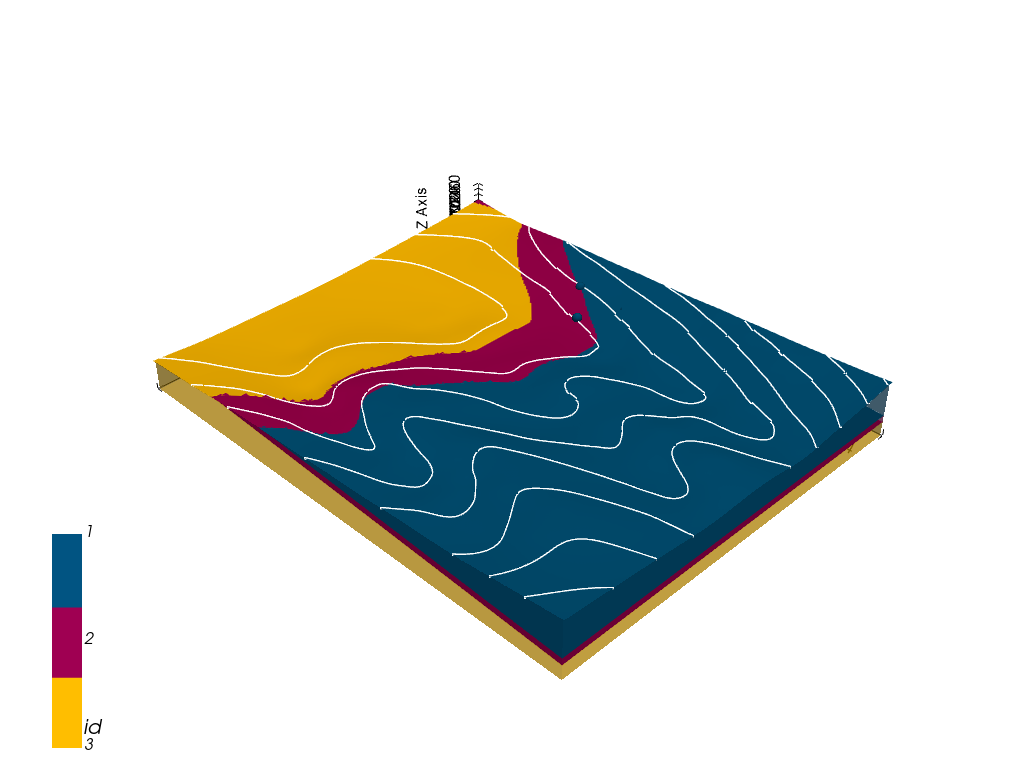

In [36]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)

### Creating Polygons from GemPy Model

A GeoDataFrame containing polygons representing the geological map can be created using `gg.post.extract_lithologies()`. This data is now being saved and the constructed layer boundaries beyond the fault in the east are being digitized. Their elevation values will be reduced by 20 m to simulate the offset of the fault. The model will then be recalculated again.

In [37]:
gdf = gg.post.extract_lithologies(geo_model, [0,1187,0,1479], 'EPSG:4326')
gdf

,formation,geometry
0,Basement,"POLYGON ((22.538 3.254, 22.804 2.498, 27.546 2..."
1,Ironstone,"POLYGON ((7.513 2.498, 12.521 2.498, 17.530 2...."
2,Ironstone,"POLYGON ((5.851 192.370, 7.513 194.147, 10.887..."
3,Shale,"POLYGON ((4.134 362.255, 7.513 365.081, 10.021..."


In [38]:
gdf = gpd.read_file(file_path + 'geolmap.shp')
gdf

,formation,geometry
0,Conglomerate,"POLYGON ((22.538 3.254, 21.064 7.495, 19.356 1..."
1,Ironstone,"POLYGON ((7.513 2.498, 2.504 2.498, 2.504 7.49..."
2,Ironstone,"POLYGON ((5.851 192.370, 2.504 188.069, 2.504 ..."
3,Shale,"POLYGON ((4.134 362.255, 2.504 360.939, 2.504 ..."


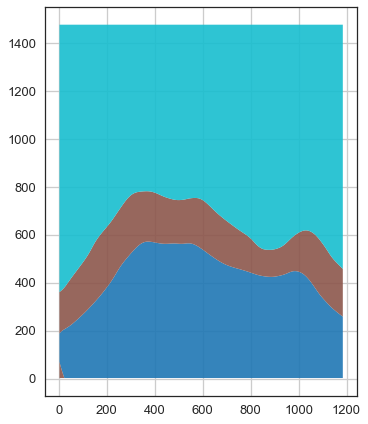

In [39]:
gdf.plot(column='formation',  alpha=0.9, aspect='equal')
plt.grid()

### Preparing Interfaces beyond the fault

In [40]:
interfaces_beyond_fault =  gpd.read_file(file_path + 'interfaces15_beyond_fault.shp')
interfaces_beyond_fault = gg.vector.extract_xyz(gdf=interfaces_beyond_fault, dem=topo_raster)
interfaces_beyond_fault

,formation,geometry,X,Y,Z
0,Shale,POINT (778.812 601.522),778.81,601.52,208.06
1,Shale,POINT (783.821 597.991),783.82,597.99,208.15
2,Shale,POINT (788.829 594.245),788.83,594.25,208.26
3,Shale,POINT (791.557 592.100),791.56,592.10,208.71
4,Shale,POINT (797.430 587.103),797.43,587.10,208.89
...,...,...,...,...,...
250,Ironstone,POINT (1169.470 270.001),1169.47,270.00,205.13
251,Ironstone,POINT (1172.985 267.319),1172.99,267.32,205.24
252,Ironstone,POINT (1174.479 266.187),1174.48,266.19,205.24
253,Ironstone,POINT (1179.487 262.439),1179.49,262.44,205.33


### Substracting the fault offset

In [41]:
interfaces_beyond_fault['Z'] = interfaces_beyond_fault['Z']-20
interfaces_beyond_fault

,formation,geometry,X,Y,Z
0,Shale,POINT (778.812 601.522),778.81,601.52,188.06
1,Shale,POINT (783.821 597.991),783.82,597.99,188.15
2,Shale,POINT (788.829 594.245),788.83,594.25,188.26
3,Shale,POINT (791.557 592.100),791.56,592.10,188.71
4,Shale,POINT (797.430 587.103),797.43,587.10,188.89
...,...,...,...,...,...
250,Ironstone,POINT (1169.470 270.001),1169.47,270.00,185.13
251,Ironstone,POINT (1172.985 267.319),1172.99,267.32,185.24
252,Ironstone,POINT (1174.479 266.187),1174.48,266.19,185.24
253,Ironstone,POINT (1179.487 262.439),1179.49,262.44,185.33


### Mergin old and new interfaces

In [42]:
interfaces_coords = pd.concat([interfaces_coords, interfaces_beyond_fault.sample(n=50)]).reset_index()
interfaces_coords

,level_0,index,formation,Z,geometry,X,Y
0,0,0.00,Shale,190.00,POINT (69.806 954.941),69.81,954.94
1,1,1.00,Ironstone,170.00,POINT (69.806 954.941),69.81,954.94
2,2,2.00,Ironstone,190.00,POINT (145.769 562.774),145.77,562.77
3,3,3.00,Ironstone,185.00,POINT (264.746 660.701),264.75,660.70
4,4,4.00,Shale,210.00,POINT (146.226 563.346),146.23,563.35
5,5,5.00,Shale,205.00,POINT (264.746 660.701),264.75,660.70
6,6,0.00,Fault,178.76,POINT (683.911 0.608),683.91,0.61
7,7,1.00,Fault,254.62,POINT (899.671 1477.524),899.67,1477.52
8,60,NaN,Shale,188.16,POINT (984.158 597.853),984.16,597.85
9,4,NaN,Shale,188.89,POINT (797.430 587.103),797.43,587.10


## GemPy Model Construction (Part B)

The structural geological model will be constructed using the `GemPy` package. 

In [43]:
import gempy as gp

### Creating new Model

In [44]:
geo_model = gp.create_model('Model15b')
geo_model

Model15b  2021-04-03 15:54

### Initiate Data


In [45]:
gp.init_data(geo_model, [0,1187,0,1479,100,300], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0],
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model15b  2021-04-03 15:54

### Model Surfaces

In [46]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Shale,Default series,1,#015482,1
1,Ironstone,Default series,2,#9f0052,2
2,Fault,Default series,3,#ffbe00,3


### Mapping the Stack to Surfaces

In [47]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Fault1' : ('Fault'),
                          'Strata1': ('Shale', 'Ironstone'),
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')
geo_model.set_is_fault(['Fault1'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Fault1,1,Fault,True,True,False
Strata1,2,Erosion,True,False,False


### Showing the Number of Data Points

In [48]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
2,Fault,Fault1,1,#527682,1,2,1
0,Shale,Strata1,1,#9f0052,2,33,1
1,Ironstone,Strata1,2,#ffbe00,3,23,1
3,Basement,Strata1,3,#728f02,4,0,0


### Loading Digital Elevation Model

In [49]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster15.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   5.935     ,    7.395     ,  101.        ],
       [   5.935     ,    7.395     ,  103.        ],
       [   5.935     ,    7.395     ,  105.        ],
       ...,
       [1184.49578059, 1466.50844595,  275.3008728 ],
       [1184.49578059, 1471.50506757,  275.80532837],
       [1184.49578059, 1476.50168919,  276.31124878]])

### Plotting Input Data

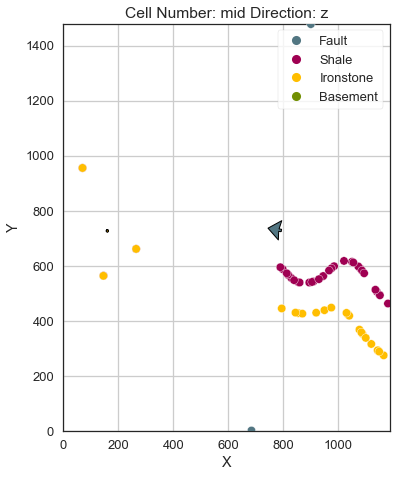

In [50]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

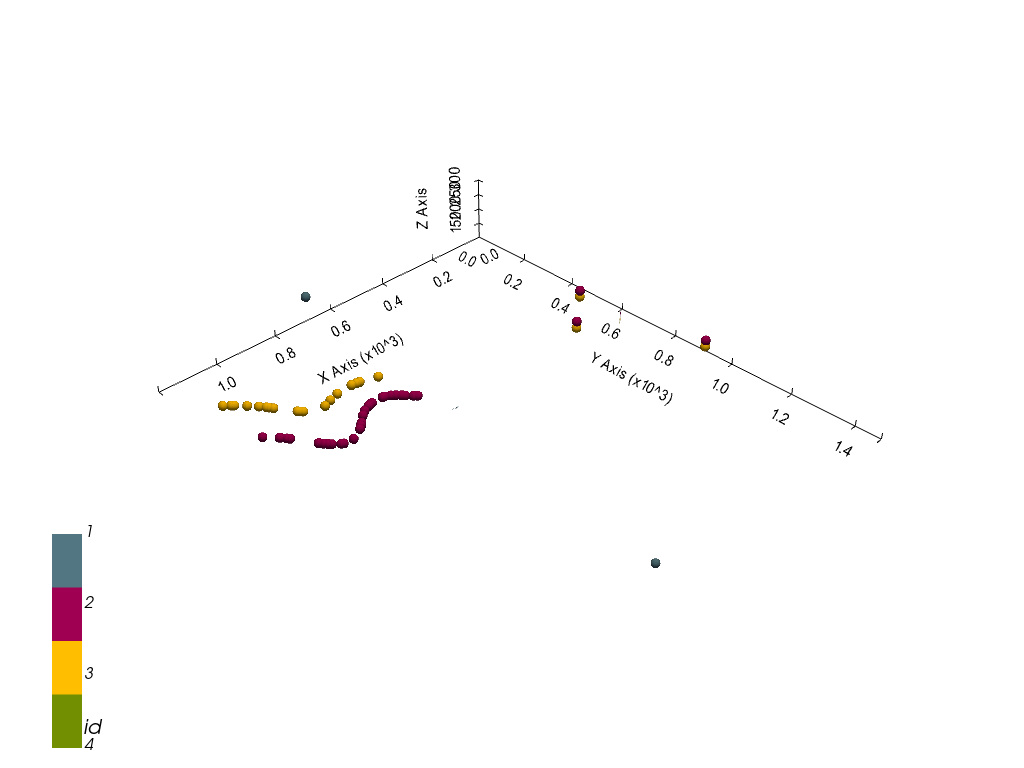

In [51]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [52]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                   values
range            1906.94
$C_o$           86581.19
drift equations   [3, 3]


### Computing Model

In [53]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

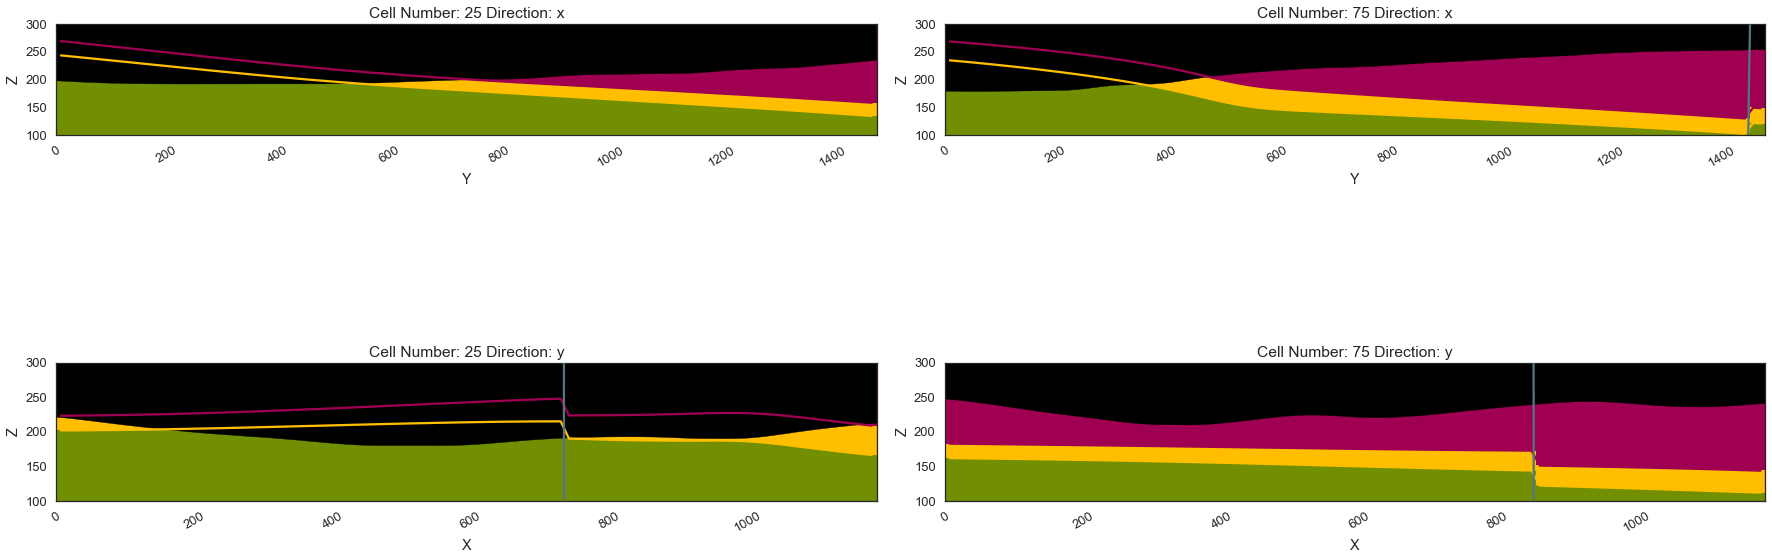

In [54]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

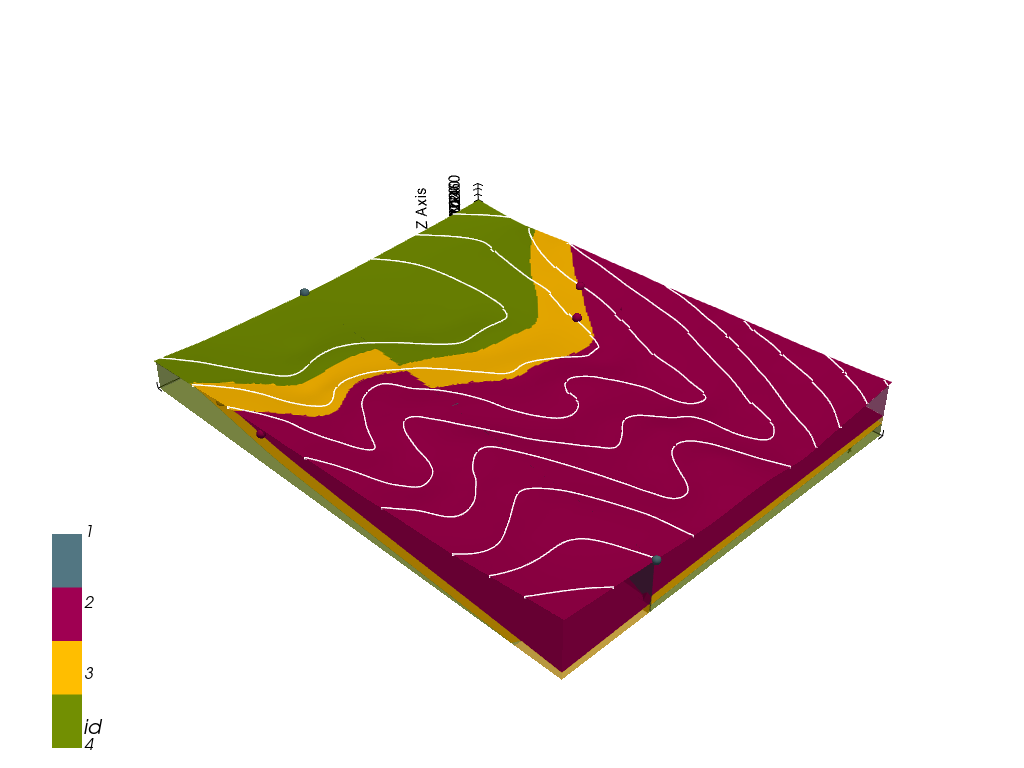

In [55]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)